In [2]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils,mask_backward_v1
import matplotlib.pyplot as plt
# from maskbackward import mask_backward
from mask_backward_v1 import mask_backward, mask_eval
from utils import *

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [2]:
# data_gt = np.load('/home/huangz78/data/data_gt.npz')
# datafornn = np.load('/home/huangz78/data/datafornn.npz')
data = np.load('/home/huangz78/data/traindata_x.npz')
dtyp = torch.float
xfull = torch.tensor(data['xfull'],dtype=dtyp)
fullmask = torch.tensor(data['mask']) # a random mask

##### greedy mask and relevant data

In [6]:
from sklearn.model_selection import train_test_split

imgs   = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
masks  = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled
imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))

In [2]:
### load a mnet

corefreq = 8 # 24
budget   = 32 # 56
from mnet import MNet
# mnet = MNet(out_size=320-24)
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnetpath = '/home/huangz78/checkpoints/mnet.pth'
# checkpoint = torch.load(mnetpath)
# mnet.load_state_dict(checkpoint['model_state_dict'])
mnet.eval()
# print('MNet loaded successfully from: ' + mnetpath)

MNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, 

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname == 'DoubleConv':
        for ind in range(4):
            subclassname = m.double_conv[ind].__class__.__name__
            if subclassname.find('Conv') != -1:
                nn.init.normal_(m.double_conv[ind].weight.data, 0.0, 0.02)
            elif subclassname.find('BatchNorm') != -1:
                nn.init.normal_(m.double_conv[ind].weight.data, 1.0, 0.02)
                nn.init.constant_(m.double_conv[ind].bias.data, 0)
            elif subclassname.find('Linear') != -1:
                nn.init.normal_(m.double_conv[ind].weight.data, 1.0, 0.02)
                nn.init.constant_(m.double_conv[ind].bias.data, 0)
    elif classname == 'OutConv':
        pass   
    else:
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        elif classname.find('Linear') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [31]:
mnet.apply(weights_init)

Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Sequential(
  (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)
DoubleConv(
  (double_conv): Sequential(
    (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Sequential(
  (0): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)
DoubleConv(
  (double_conv): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Bat

MNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, 

In [4]:
# reload(utils)
# from utils import hfen
# reload(mask_backward_new)
# from mask_backward_new import mask_backward, mask_eval
import unet_model
reload(unet_model)
from unet_model import UNet

In [5]:
### load a unet for maskbackward
# UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
# unetpath = '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth'
# unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'

unet_skip = True
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
checkpoint = torch.load(unetpath)
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
UNET.train()
print('nn\'s are ready')

Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
nn's are ready


In [9]:
# batchsize = 5
xstar = xfull[0,:,:].view(-1,320,320)
# xstar    = imgs[testinds[testinds.size//2:],:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()
# full_gredmask = masks[testinds[testinds.size//2:],:]

yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho')).to(torch.cfloat) # y is ROLLED!

lowfreqmask,_,_ = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)

z = apply_mask(lowfreqmask,yfull,mode='r')

highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],int(highmask[ind,:].sum()),replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=torch.sum(highmask[0,:]),other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)
# x_lf     = get_x_f_from_yfull(lowfreqmask,yfull)
# highmask = sigmoid_binarize(mnet(x_lf.view(batchsize,1,xstar.shape[1],xstar.shape[2])))

NN         = 10
# alpha_grid = 10**(np.linspace(-5.5,-3.5,NN))
alpha_grid = 10**(np.linspace(-8,-5,NN))
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
l2loss   = np.zeros((NN,5))
hfen = np.zeros((NN,5))
sparsity = np.zeros((NN,5))
########################################  
## (1) mask_backward
########################################    
maxIter_mb = 15
lr_mb      = 1e-2

# alpha = 1e-5
# c = 1e-2

In [28]:
# for (8,32) setting
maxIter_mb = 40
lr_mb      = 1e-2
print('preselect_num = ',corefreq)
print('budget = ',budget)

xstar = xfull[0,:,:].view(-1,320,320)
# xstar    = imgs[testinds[testinds.size//2:],:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

# base_eq = torch.flatten( torch.tensor( [[1,0] for i in range(budget//2)] ) )
# highmask = torch.zeros((320-corefreq))
# highmask[(320-corefreq - budget)//2:(320-corefreq+budget)//2] = base_eq
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=2*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.view(-1,320-corefreq)

mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                  beta=1.,alpha=10**(-4),c=0,\
                  maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                  lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                  verbose=True,dtyp=torch.float,testmode='sigpy',hfen=False,return_loss_only=False,\
                  save_cp=False)

preselect_num =  8
budget =  32
loss of the input mask:  0.16711479425430298
Iter 14, rows added: 0.0, rows reducted: 6.0, current samp. ratio: 0.20625
Iter 15, rows added: 0.0, rows reducted: 11.0, current samp. ratio: 0.171875
Iter 34, rows added: 0.0, rows reducted: 1.0, current samp. ratio: 0.16875
Iter 35, rows added: 0.0, rows reducted: 4.0, current samp. ratio: 0.15625
Iter 36, rows added: 0.0, rows reducted: 5.0, current samp. ratio: 0.140625
Iter 37, rows added: 1.0, rows reducted: 3.0, current samp. ratio: 0.134375
Iter 38, rows added: 2.0, rows reducted: 2.0, current samp. ratio: 0.134375
Iter 39, rows added: 2.0, rows reducted: 8.0, current samp. ratio: 0.115625
Iter 40, rows added: 3.0, rows reducted: 2.0, current samp. ratio: 0.11875
Iter 41, rows added: 2.0, rows reducted: 6.0, current samp. ratio: 0.10625
Iter 42, rows added: 1.0, rows reducted: 1.0, current samp. ratio: 0.10625
Iter 43, rows added: 1.0, rows reducted: 2.0, current samp. ratio: 0.103125
Iter 44, rows ad

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
          1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
          1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
          0., 0.

In [6]:
res_path = '/home/huangz78/checkpoints/mb_rec.npz'
res = np.load(res_path)
l2loss   = res['l2loss']
hfen     = res['hfen']
sparsity = res['sparsity']

In [8]:
# for (24,56) setting
mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
              beta=1.,alpha=10**(-9.5),c=1e-2,\
              maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
              lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
              verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=True)

Iter 11, rows added: 0.3, rows reducted: 0.0
Iter 12, rows added: 1.15, rows reducted: 0.0
Iter 13, rows added: 6.9, rows reducted: 0.05
Iter 14, rows added: 5.05, rows reducted: 0.3
Iter 15, rows added: 13.7, rows reducted: 0.65

return at Iter ind:  15
loss of returned mask: (0.07968779474096067, 0.46277795499311036)
samp. ratio: 0.3315625, Recon. rel. err: 0.12961633205187212 



((0.07968779474096067, 0.46277795499311036), 0.3315625)

# 8-fold check

In [3]:
### load a mnet

corefreq = 8
budget   = 32
from mnet import MNet
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
mnet.eval()
print('mnet is initialized')

MNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(256, eps=1e-05, 

In [24]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 11
alpha_grid = 10**(np.linspace(-5,-3,NN))
c_grid     = np.array([1e-5,1e-4,1e-3,1e-2,1e-1])

l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True

In [25]:
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
        
        UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
        unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        print('Unet loaded successfully from: ' + unetpath )
        UNET.train()
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

c_ind 1 out of 5
alpha_ind 1 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600858867168428, 0.8251760840415955)
Iter 15, rows added: 2.8, rows reducted: 0.2, current samp. ratio: 0.183125
Iter 16, rows added: 22.8, rows reducted: 0.0, current samp. ratio: 0.254375
Iter 17, rows added: 11.6, rows reducted: 0.0, current samp. ratio: 0.290625
Iter 18, rows added: 8.0, rows reducted: 0.0, current samp. ratio: 0.315625
Iter 19, rows added: 1.8, rows reducted: 1.0, current samp. ratio: 0.318125
Iter 20, rows added: 7.2, rows reducted: 0.4, current samp. ratio: 0.339375
Iter 21, rows added: 0.2, rows reducted: 2.2, current samp. ratio: 0.333125
Iter 22, rows added: 3.8, rows reducted: 0.2, current samp. ratio: 0.344375
Iter 23, rows added: 0.4, rows reducted: 1.8, current samp. ratio: 0.34
Iter 24, rows added: 1.2, rows reducted: 0.6, current samp. ratio: 0.341875
Iter 25, rows added: 0.0, rows reducted: 1.4, current samp. ra

Iter 22, rows added: 2.6, rows reducted: 0.0, current samp. ratio: 0.116875
Iter 23, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.1175
Iter 24, rows added: 2.2, rows reducted: 0.0, current samp. ratio: 0.124375
Iter 25, rows added: 0.8, rows reducted: 0.0, current samp. ratio: 0.126875
Iter 26, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.12875
Iter 27, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.130625
Iter 28, rows added: 1.4, rows reducted: 0.0, current samp. ratio: 0.135
Iter 29, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.135625
Iter 30, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.139375

return at Iter ind:  30
loss of returned mask: (0.10330692529678345, 0.7448447465896606)
samp. ratio: 0.119375, Recon. rel. err: 0.14567764103412628 

alpha_ind 6 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600855588912963, 0.8251757502555848)
Iter 9,

Iter 19, rows added: 2.0, rows reducted: 1.0, current samp. ratio: 0.31875
Iter 20, rows added: 7.0, rows reducted: 0.4, current samp. ratio: 0.339375
Iter 21, rows added: 0.2, rows reducted: 2.2, current samp. ratio: 0.333125
Iter 22, rows added: 3.8, rows reducted: 0.2, current samp. ratio: 0.344375
Iter 23, rows added: 0.4, rows reducted: 1.8, current samp. ratio: 0.34
Iter 24, rows added: 1.2, rows reducted: 0.6, current samp. ratio: 0.341875
Iter 25, rows added: 0.2, rows reducted: 1.6, current samp. ratio: 0.3375
Iter 26, rows added: 1.4, rows reducted: 0.2, current samp. ratio: 0.34125
Iter 27, rows added: 0.0, rows reducted: 1.0, current samp. ratio: 0.338125
Iter 28, rows added: 1.8, rows reducted: 0.0, current samp. ratio: 0.34375
Iter 29, rows added: 0.0, rows reducted: 1.4, current samp. ratio: 0.339375
Iter 30, rows added: 1.6, rows reducted: 0.0, current samp. ratio: 0.344375

return at Iter ind:  30
loss of returned mask: (0.07595335543155671, 0.5736945629119873)
samp. r

Iter 29, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.135625
Iter 30, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.139375

return at Iter ind:  30
loss of returned mask: (0.10330691933631897, 0.7448447227478028)
samp. ratio: 0.119375, Recon. rel. err: 0.14567916095256805 

alpha_ind 6 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600849032402037, 0.825175154209137)
Iter 9, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.174375
Iter 10, rows added: 0.0, rows reducted: 25.4, current samp. ratio: 0.095
Iter 11, rows added: 0.0, rows reducted: 16.6, current samp. ratio: 0.043125
Iter 12, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.0425
Iter 13, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.043125
Iter 17, rows added: 0.8, rows reducted: 0.0, current samp. ratio: 0.045625
Iter 18, rows added: 5.2, rows reducted: 0.0, current samp. ratio: 0.061875
Iter 1

Iter 25, rows added: 0.4, rows reducted: 1.8, current samp. ratio: 0.3375
Iter 26, rows added: 1.8, rows reducted: 0.6, current samp. ratio: 0.34125
Iter 27, rows added: 0.2, rows reducted: 1.2, current samp. ratio: 0.338125
Iter 28, rows added: 1.6, rows reducted: 0.2, current samp. ratio: 0.3425
Iter 29, rows added: 0.2, rows reducted: 1.0, current samp. ratio: 0.34
Iter 30, rows added: 1.6, rows reducted: 0.2, current samp. ratio: 0.344375

return at Iter ind:  30
loss of returned mask: (0.07580353170633317, 0.5720462799072266)
samp. ratio: 0.324375, Recon. rel. err: 0.13317276537418365 

alpha_ind 2 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600842475891114, 0.8251745700836182)
Iter 9, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.174375
Iter 10, rows added: 0.0, rows reducted: 0.6, current samp. ratio: 0.1725
Iter 11, rows added: 0.0, rows reducted: 2.0, current samp. ratio: 0.16625
Iter 12, rows 

Iter 9, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.174375
Iter 10, rows added: 0.0, rows reducted: 25.4, current samp. ratio: 0.095
Iter 11, rows added: 0.0, rows reducted: 16.6, current samp. ratio: 0.043125
Iter 12, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.0425
Iter 13, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.043125
Iter 17, rows added: 0.8, rows reducted: 0.0, current samp. ratio: 0.045625
Iter 18, rows added: 5.2, rows reducted: 0.0, current samp. ratio: 0.061875
Iter 19, rows added: 4.0, rows reducted: 0.0, current samp. ratio: 0.074375
Iter 20, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.078125
Iter 21, rows added: 2.2, rows reducted: 0.0, current samp. ratio: 0.085
Iter 22, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.08875
Iter 23, rows added: 1.8, rows reducted: 0.0, current samp. ratio: 0.094375
Iter 24, rows added: 1.0, rows reducted: 0.0, current samp. ratio: 0.0975
Iter 25, rows added: 1

Iter 29, rows added: 1.2, rows reducted: 2.4, current samp. ratio: 0.40625
Iter 30, rows added: 4.6, rows reducted: 0.8, current samp. ratio: 0.418125

return at Iter ind:  30
loss of returned mask: (0.06887954324483872, 0.5222813844680786)
samp. ratio: 0.398125, Recon. rel. err: 0.1330125778913498 

alpha_ind 2 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600844264030457, 0.8251747250556946)
Iter 10, rows added: 0.0, rows reducted: 0.4, current samp. ratio: 0.17375
Iter 11, rows added: 0.0, rows reducted: 5.0, current samp. ratio: 0.158125
Iter 12, rows added: 0.0, rows reducted: 2.6, current samp. ratio: 0.15
Iter 13, rows added: 0.0, rows reducted: 2.8, current samp. ratio: 0.14125
Iter 14, rows added: 0.6, rows reducted: 1.2, current samp. ratio: 0.139375
Iter 15, rows added: 0.4, rows reducted: 3.4, current samp. ratio: 0.13
Iter 16, rows added: 14.2, rows reducted: 0.4, current samp. ratio: 0.173125
Iter 17, row

Iter 14, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.04375
Iter 17, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.045625
Iter 18, rows added: 5.4, rows reducted: 0.0, current samp. ratio: 0.0625
Iter 19, rows added: 4.0, rows reducted: 0.0, current samp. ratio: 0.075
Iter 20, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.07875
Iter 21, rows added: 2.2, rows reducted: 0.0, current samp. ratio: 0.085625
Iter 22, rows added: 1.6, rows reducted: 0.0, current samp. ratio: 0.090625
Iter 23, rows added: 1.4, rows reducted: 0.0, current samp. ratio: 0.095
Iter 24, rows added: 1.0, rows reducted: 0.0, current samp. ratio: 0.098125
Iter 25, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.1
Iter 26, rows added: 1.4, rows reducted: 0.0, current samp. ratio: 0.104375
Iter 27, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.105
Iter 29, rows added: 0.2, rows reducted: 0.0, current samp. ratio: 0.105625
Iter 30, rows added: 0.8, rows


return at Iter ind:  30
loss of returned mask: (0.06413249671459198, 0.4808450222015381)
samp. ratio: 0.486875, Recon. rel. err: 0.13306863605976105 

alpha_ind 2 out of 11
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.16600847542285918, 0.8251750826835632)
Iter 9, rows added: 0.0, rows reducted: 1.8, current samp. ratio: 0.169375
Iter 10, rows added: 0.0, rows reducted: 5.0, current samp. ratio: 0.15375
Iter 11, rows added: 0.0, rows reducted: 18.8, current samp. ratio: 0.095
Iter 12, rows added: 0.0, rows reducted: 1.2, current samp. ratio: 0.09125
Iter 13, rows added: 10.0, rows reducted: 0.2, current samp. ratio: 0.121875
Iter 14, rows added: 20.2, rows reducted: 0.0, current samp. ratio: 0.185
Iter 15, rows added: 27.2, rows reducted: 0.0, current samp. ratio: 0.27
Iter 16, rows added: 21.8, rows reducted: 0.0, current samp. ratio: 0.338125
Iter 17, rows added: 16.0, rows reducted: 0.0, current samp. ratio: 0.388125
Iter 18,

Iter 12, rows added: 0.0, rows reducted: 0.4, current samp. ratio: 0.0425
Iter 14, rows added: 0.0, rows reducted: 0.2, current samp. ratio: 0.041875
Iter 15, rows added: 0.2, rows reducted: 0.2, current samp. ratio: 0.041875
Iter 17, rows added: 2.4, rows reducted: 0.2, current samp. ratio: 0.04875
Iter 18, rows added: 3.0, rows reducted: 0.0, current samp. ratio: 0.058125
Iter 19, rows added: 3.0, rows reducted: 0.0, current samp. ratio: 0.0675
Iter 20, rows added: 3.0, rows reducted: 0.0, current samp. ratio: 0.076875
Iter 21, rows added: 1.6, rows reducted: 0.2, current samp. ratio: 0.08125
Iter 22, rows added: 0.6, rows reducted: 0.0, current samp. ratio: 0.083125
Iter 23, rows added: 1.0, rows reducted: 0.4, current samp. ratio: 0.085
Iter 24, rows added: 1.6, rows reducted: 0.0, current samp. ratio: 0.09
Iter 25, rows added: 1.2, rows reducted: 0.0, current samp. ratio: 0.09375
Iter 26, rows added: 1.4, rows reducted: 0.0, current samp. ratio: 0.098125
Iter 27, rows added: 0.8, 

In [27]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [28]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

mode = sigpy
0.17513811588287354
0.10690503120422364


In [23]:
# kplot(full_lowfmask[2,:])

In [38]:
np.log10(alpha_grid[4])

-4.2

Text(0.5, 0, 'alpha')

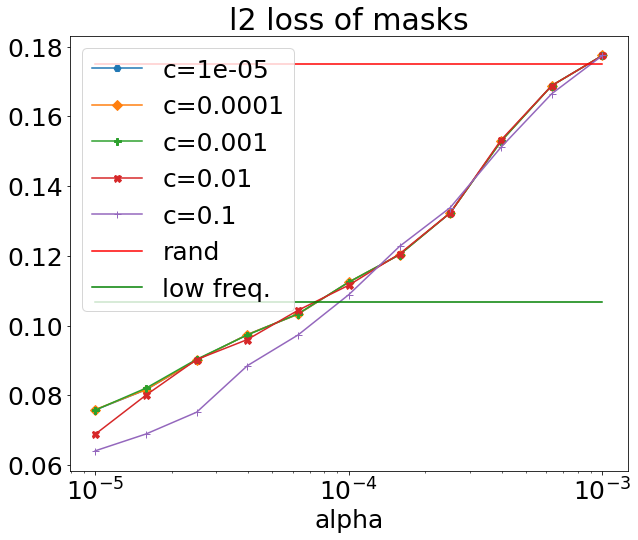

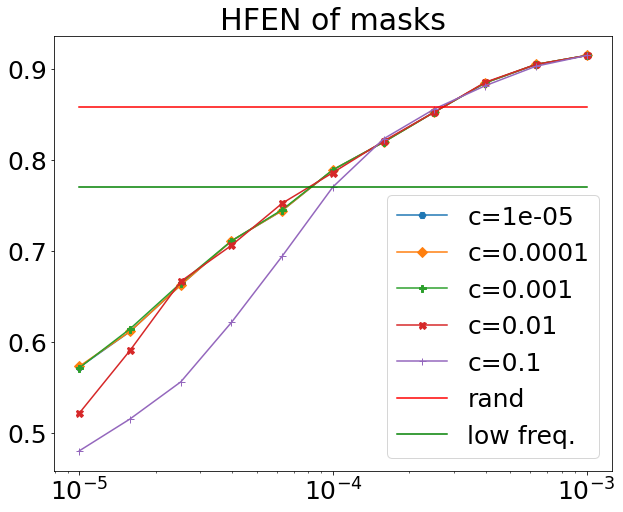

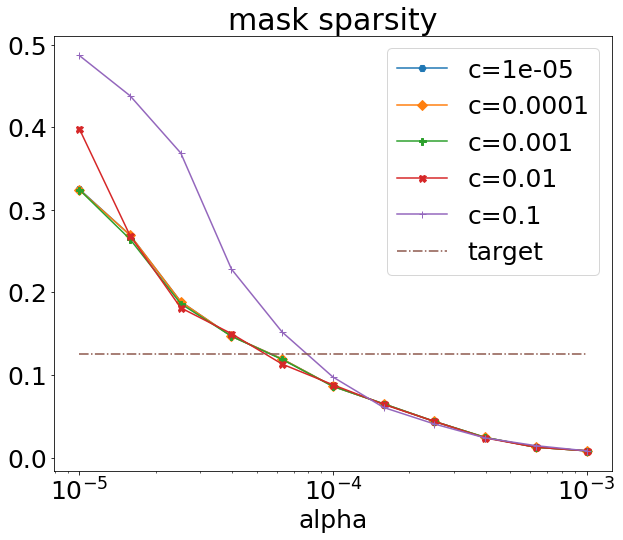

In [36]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

# 4-fold check

In [ ]:
c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
        UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
        unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        UNET.train()
    # highmask_refined,unet = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
    #                   beta=1.,alpha=alpha,c=c,\
    #                   maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
    #                   lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
    #                   verbose=True,dtyp=torch.float)
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True)
        a_ind += 1
    print('\n')
    c_ind += 1

c_ind 1 out of 5
alpha_ind 1 out of 9


/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554786529/work/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Iter 10, rows added: 0.1, rows reducted: 0.0
Iter 11, rows added: 0.7, rows reducted: 0.1
Iter 12, rows added: 12.65, rows reducted: 0.0
Iter 13, rows added: 130.2, rows reducted: 0.05
Iter 14, rows added: 78.55, rows reducted: 0.0
Iter 15, rows added: 7.45, rows reducted: 0.0

return at Iter ind:  15
loss of returned mask: (0.00915240696204989, 0.0496024175095589)
samp. ratio: 0.9671875, Recon. rel. err: 0.060508316646377694 

alpha_ind 2 out of 9
Iter 11, rows added: 0.7, rows reducted: 0.0
Iter 12, rows added: 14.2, rows reducted: 0.0
Iter 13, rows added: 60.45, rows reducted: 0.0
Iter 14, rows added: 105.1, rows reducted: 7.85
Iter 15, rows added: 32.75, rows reducted: 0.15

return at Iter ind:  15
loss of returned mask: (0.018273703625847623, 0.09272527920854942)
samp. ratio: 0.89125, Recon. rel. err: 0.07882034908293895 

alpha_ind 3 out of 9
Iter 12, rows added: 1.9, rows reducted: 0.0
Iter 13, rows added: 19.3, rows reducted: 0.0
Iter 14, rows added: 141.45, rows reducted: 0.0


In [14]:
full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

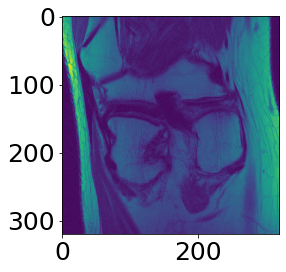

In [17]:
plt.imshow(xstar[0,:,:])

In [12]:
# mnet_loss = mask_eval(full_highmask,xstar,mode='UNET',UNET=UNET)
# rand_loss = mask_eval(full_randmask,xstar,mode='UNET',UNET=UNET)
# lowf_loss = mask_eval(full_lowfmask,xstar,mode='UNET',UNET=UNET)
# print('mode = UNet')
# mnet_loss = mask_eval(full_highmask,xstar,mode='sigpy')
(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
(gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')
# print(mnet_loss)

print(rand_l2)
print(lowf_l2)
print(gred_l2)

mode = sigpy
0.13491943476441687
0.09845167268726558
0.10988322834230227


ValueError: x and y must have same first dimension, but have shapes (9,) and (10, 5)

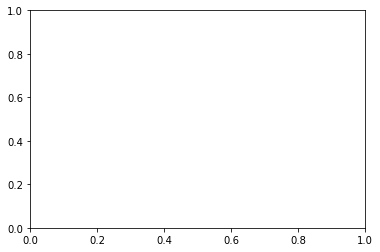

In [20]:
plt.figure()
plt.plot(alpha_grid,l2loss)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,label='greedy')
plt.title('l2 loss of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,hfen)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,sparsity,label='actual')
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')

Text(0.5, 0, 'alpha')

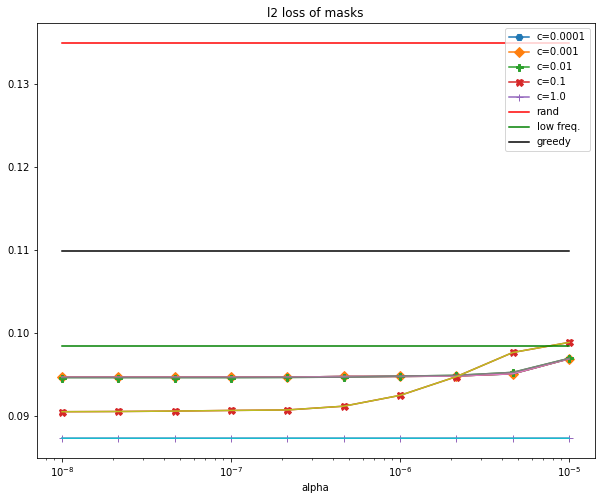

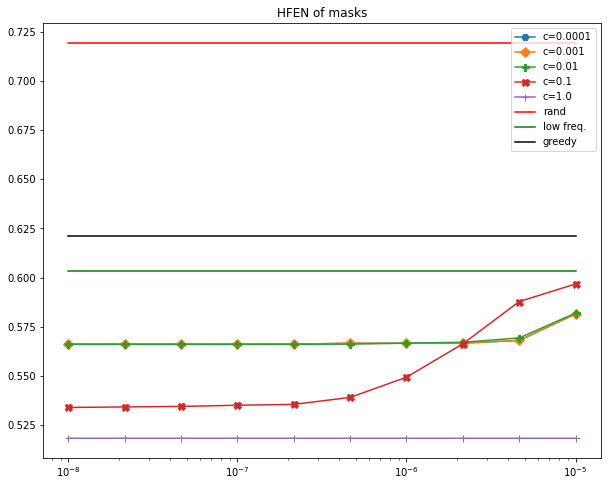

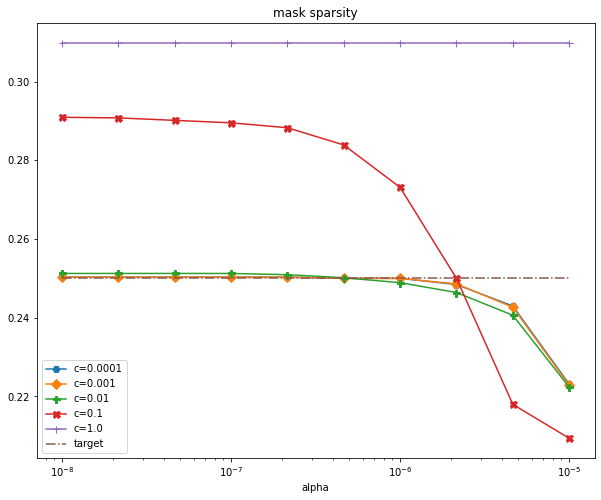

In [18]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,color='k',label='greedy')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,color='k',label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

In [4]:
NN         = 10
alpha_grid = 10**(np.linspace(-8,-5,NN))
np.linspace(-8,-5,NN)[-3]

-5.666666666666667

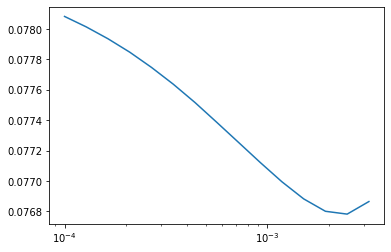

In [14]:
from sigpy.mri.app import TotalVariationRecon
xstar = imgs[0,:,:]/torch.max(torch.abs(imgs[0,:,:].flatten()))
imgHeg, imgWid = xstar.shape[0], xstar.shape[1]
mps = np.ones((1,imgHeg,imgWid))
imgind = 15

NN = 15
Lambda_grid = 10**(np.linspace(-4,-2.5,NN))
errors = np.zeros((NN))

y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'),dim=(0,1))    
z = torch.zeros(y.shape).to(y.dtype)
z[masks[imgind,:]==1,:] = y[masks[imgind,:]==1,:]  
y_tmp = z.view(-1,imgHeg,imgWid).numpy()

xstar = xstar.numpy()

ind = 0
for Lambda in Lambda_grid:    
    x_tmp = np.fft.ifftshift( np.abs(TotalVariationRecon(y_tmp, mps, Lambda, show_pbar=False).run()) )  
    errors[ind] = np.linalg.norm(x_tmp - xstar,'fro')/np.linalg.norm(xstar,'fro')
    ind += 1
    
plt.figure()
plt.plot(Lambda_grid,errors)
plt.xscale('log')
plt.show()

### old tests

In [ ]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,27]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [ ]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1

highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

In [ ]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

In [ ]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

In [ ]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [ ]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

In [ ]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [ ]:
np.linspace(-6,-4,gridnum)[8]

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### mask binarize test

In [47]:
from torch.autograd import Function
class ThresholdBinarizeMask(Function):
    def __init__(self):
        """
            Straight through estimator.
            The forward step binarizes the real-valued mask.
            The backward step estimate the non differentiable > operator using sigmoid with large slope (10).
        """
        super(ThresholdBinarizeMask, self).__init__()

    @staticmethod
    def forward(ctx, input):
        batch_size = len(input)
        results = [] 

        for i in range(batch_size):
            x = input[i:i+1]
            result = (x > .5).float()
            results.append(result)

        results = torch.cat(results, dim=0)
#         ctx.save_for_backward(input)
        return results  

    @staticmethod
    def backward(ctx, grad_output):
        slope = 1
#         input = ctx.saved_tensors

        # derivative of M
        current_grad = slope

        return current_grad * grad_output

In [48]:
threshold = ThresholdBinarizeMask.apply

In [62]:
x = torch.tensor([.1,.3,.7,.9,.6,.5,.21,.43])
x.requires_grad = True
b = threshold(x)

In [63]:
y = torch.tensor([1., 1., 1., 1., 0., 1., 0., 1.])
loss = torch.norm((y-b),p=2)**2

In [64]:
optimizer = optim.SGD([{'params': x}], lr=1e-2)

In [65]:
optimizer.zero_grad()
loss.backward()
print('old x: ', x)
print('grad: ', x.grad)
optimizer.step()
print('updated x: ', x)

old x:  tensor([0.1000, 0.3000, 0.7000, 0.9000, 0.6000, 0.5000, 0.2100, 0.4300],
       requires_grad=True)
grad:  tensor([-2., -2., -0., -0.,  2., -2., -0., -2.])
updated x:  tensor([0.1200, 0.3200, 0.7000, 0.9000, 0.5800, 0.5200, 0.2100, 0.4500],
       requires_grad=True)


### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)

In [ ]:
### verify that UNET works fine
z = apply_mask(full_gredmask,yfull,mode='c')
xs = torch.abs(F.ifftn(F.ifftshift(z),dim=(1,2),norm='ortho'))
xs = torch.reshape(xs,(xs.shape[0],1,xs.shape[1],xs.shape[2]))

UNET.eval()
imgind = 0
xrecon = UNET(xs)
plt.figure()
plt.title('recon')
plt.imshow(xrecon.detach().numpy()[imgind,0,:,:])
plt.colorbar()
plt.show()

plt.figure()
plt.title('gt')
plt.imshow(xstar.detach().numpy()[imgind,:,:])
plt.colorbar()
plt.show()
print(torch.norm(xrecon[imgind,0,:,:]-xstar[imgind,:,:],'fro')/torch.norm(xstar[imgind,:,:],'fro').item())

In [ ]:
reload(utils)
from utils import hfen

In [ ]:
torch.squeeze(xrecon)[0,:,:].shape

In [ ]:
hfen(torch.squeeze(xrecon)[imgind,:,:],xstar[imgind,:,:],base=0)